In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Base paths (relative to /notebooks)
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"

TRACKS_FEATURES_PATH = DATA_RAW / "tracks_features.csv"
MPD_DIR = DATA_RAW / "mpd"

TRACKS_FEATURES_PATH, MPD_DIR

(WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/tracks_features.csv'),
 WindowsPath('C:/Users/Kiera/Music_Recommender/data/raw/mpd'))

In [2]:
# Load the features CSV (1.2M-ish rows)
tracks_df = pd.read_csv(TRACKS_FEATURES_PATH)

print("tracks_features.csv shape:", tracks_df.shape)
tracks_df.head()

tracks_features.csv shape: (1204025, 24)


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [3]:
# We’ll assume 'id' is the Spotify track ID string
unique_feature_track_ids = set(tracks_df["id"].dropna().astype(str))

print(f"Unique track IDs in tracks_features.csv: {len(unique_feature_track_ids):,}")


Unique track IDs in tracks_features.csv: 1,204,025


In [4]:
def extract_track_id_from_uri(track_uri: str) -> str:
    """
    Convert 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI' → '0UaMYEvWZi0ZqiDOoHU3YI'.
    """
    if not isinstance(track_uri, str):
        return None
    parts = track_uri.split(":")
    return parts[-1] if len(parts) >= 3 else None

# Quick sanity check
test_uri = "spotify:track:0UaMYEvWZi0ZqiDOoHU3YI"
extract_track_id_from_uri(test_uri)


'0UaMYEvWZi0ZqiDOoHU3YI'

In [5]:
from tqdm.auto import tqdm

mpd_files = sorted(MPD_DIR.glob("mpd.slice.*.json"))
print(f"Found {len(mpd_files)} MPD slice files")

mpd_track_ids = set()
playlist_count = 0
track_count = 0

for path in tqdm(mpd_files):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    playlists = data.get("playlists", [])
    playlist_count += len(playlists)
    
    for pl in playlists:
        tracks = pl.get("tracks", [])
        track_count += len(tracks)
        for t in tracks:
            uri = t.get("track_uri")
            tid = extract_track_id_from_uri(uri)
            if tid:
                mpd_track_ids.add(tid)

print(f"Total playlists in MPD slices: {playlist_count:,}")
print(f"Total track entries (with duplicates) in MPD slices: {track_count:,}")
print(f"Unique track IDs in MPD: {len(mpd_track_ids):,}")


Found 20 MPD slice files


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 20/20 [00:30<00:00,  1.51s/it]

Total playlists in MPD slices: 20,000
Total track entries (with duplicates) in MPD slices: 1,339,962
Unique track IDs in MPD: 261,689


In [6]:
# Sizes
n_mpd = len(mpd_track_ids)
n_feat = len(unique_feature_track_ids)

intersection_ids = mpd_track_ids & unique_feature_track_ids
n_intersection = len(intersection_ids)

print(f"Unique track IDs in MPD: {n_mpd:,}")
print(f"Unique track IDs in tracks_features.csv: {n_feat:,}")
print(f"Overlap (tracks in both): {n_intersection:,}")

print(f"  - % of MPD tracks covered by features: {n_intersection / n_mpd * 100:.2f}%")
print(f"  - % of feature tracks that appear in MPD: {n_intersection / n_feat * 100:.2f}%")


Unique track IDs in MPD: 261,689
Unique track IDs in tracks_features.csv: 1,204,025
Overlap (tracks in both): 21,550
  - % of MPD tracks covered by features: 8.23%
  - % of feature tracks that appear in MPD: 1.79%


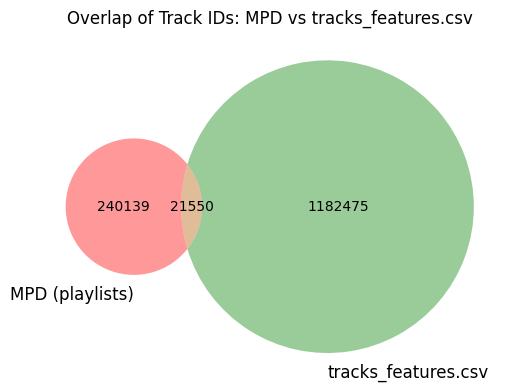

In [8]:
plt.figure(figsize=(6, 6))
venn2(
    subsets=(
        n_mpd - n_intersection,          # MPD only
        n_feat - n_intersection,         # Features only
        n_intersection                   # Both
    ),
    set_labels=("MPD (playlists)", "tracks_features.csv")
)
plt.title("Overlap of Track IDs: MPD vs tracks_features.csv")
plt.show()